# Speech Recognition from Scratch
Based on an end-to-end speech recogition engine similar to DeepSpeech2: https://keras.io/examples/audio/ctc_asr/

Processing steps are:
- data preparation (LibriSpeech: training set of 360 hours "clean" speech & test set)
- character-tokenization
- conversion of audio to mel-spectrograms
- tensorflow input pipeline
- recurrent neural network
- ctc-loss-function
- word-error-rate calculation

In [1]:
gpu = !nvidia-smi -L
print(gpu[0])

GPU 0: A100-SXM4-40GB (UUID: GPU-d4139225-6038-155f-51dd-3ebe08297cb6)


In [34]:
!pip install jiwer
!pip install tensorflow-io==0.25
!pip install -U kaleido
!pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.0 MB/s 


In [35]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
import tensorflow_io as tfio
import tensorflow_addons as tfa
from jiwer import wer
import joblib
import IPython.display as ipd
import keras.backend as K
import plotly.express as px
from IPython.display import Image
import plotly.io as pio

In [36]:
K.clear_session()

In [37]:
from google.colab import drive, files
drive.mount('/content/drive', force_remount=True)

DATA_PATH = '/content/drive/MyDrive/LibriSpeech/'
#DATA_PATH = "G:/Meine Ablage/LibriSpeech/"

METADATA_PATH = DATA_PATH+'metadata_full.csv'
MEDIA_PATH = DATA_PATH+'media/'
MODEL_PATH = DATA_PATH+'model/'
RECORDINGS_PATH = DATA_PATH+'my_recordings/'

Mounted at /content/drive


In [38]:
data = pd.read_csv(METADATA_PATH, sep="|", header=None, quoting=3)
data.columns = ["file_path", "key", "transcription", "duration", "char_length" , "speed"]
data.head(3)

,file_path,key,transcription,duration,char_length,speed
0,/content/drive/MyDrive/LibriSpeech/train-clean...,1487-133273-0000,the second in importance is as follows soverei...,14.120,195,13.810198
1,/content/drive/MyDrive/LibriSpeech/train-clean...,1487-133273-0001,till he has given his assent to them he is mor...,12.715,183,14.392450
2,/content/drive/MyDrive/LibriSpeech/train-clean...,1487-133273-0002,since the refusal of his assent does not annul...,13.945,206,14.772320


In [39]:
data_test = pd.read_csv(DATA_PATH+"metadata_test_full.csv", sep="|", header=None, quoting=3)
data_test.columns = ["file_path", "key", "transcription", "duration", "char_length" , "speed"]
data_test.head(3)

,file_path,key,transcription,duration,char_length,speed
0,/content/drive/MyDrive/LibriSpeech/test-clean/...,2094-142345-0000,it is a very fine old place of red brick softe...,14.120,280,19.830028
1,/content/drive/MyDrive/LibriSpeech/test-clean/...,2094-142345-0001,but the windows are patched with wooden panes ...,12.715,102,8.022021
2,/content/drive/MyDrive/LibriSpeech/test-clean/...,2094-142345-0002,for it is a solid heavy handsome door and must...,13.945,213,15.274292


### Duration

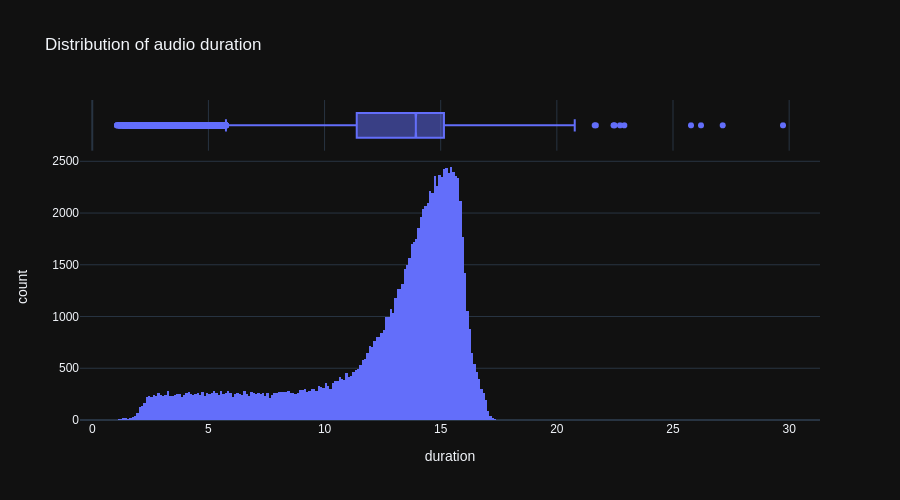

In [40]:
fig = px.histogram(data, x="duration", marginal="box", nbins=500, template='plotly_dark',
                  title='Distribution of audio duration')
Image(pio.to_image(fig, format='png', width=900))

In [41]:
min = 6
initial_size = data.shape[0]
data = data[data['duration'] >= min]
print(f'percentage of data lost after removing audio files with less than {min} second duration: '
     f'{(((initial_size-data.shape[0])/initial_size) * 100):.4f}%')

percentage of data lost after removing audio files with less than 6 second duration: 9.4824%


In [42]:
max = 17
initial_size = data.shape[0]
data = data[data['duration'] <= max]
print(f'percentage of data lost after removing audio files with more than {max} seconds duration: '
     f'{(((initial_size-data.shape[0])/initial_size) * 100):.4f}%')

percentage of data lost after removing audio files with more than 17 seconds duration: 0.1933%


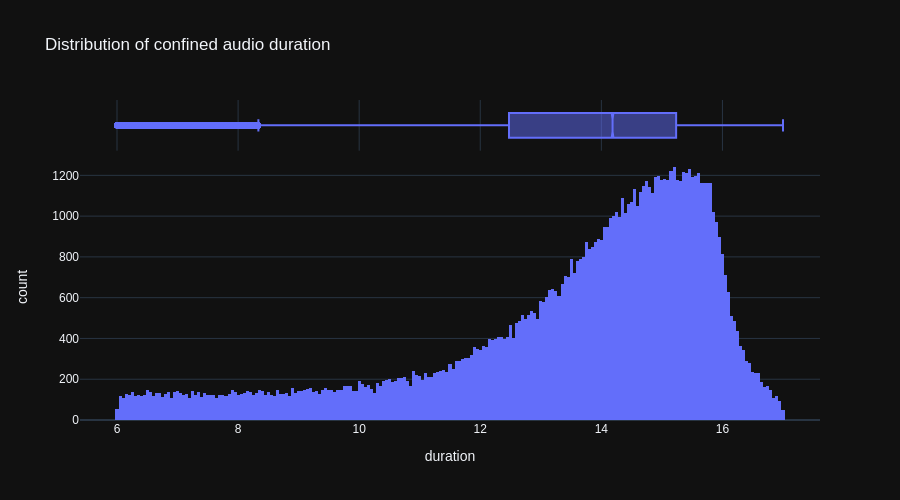

In [43]:
fig = px.histogram(data, x="duration", marginal="box", nbins=500, template='plotly_dark', title='Distribution of confined audio duration')
Image(pio.to_image(fig, format='png', width=900))

In [44]:
data.shape

(93969, 6)

### Speed

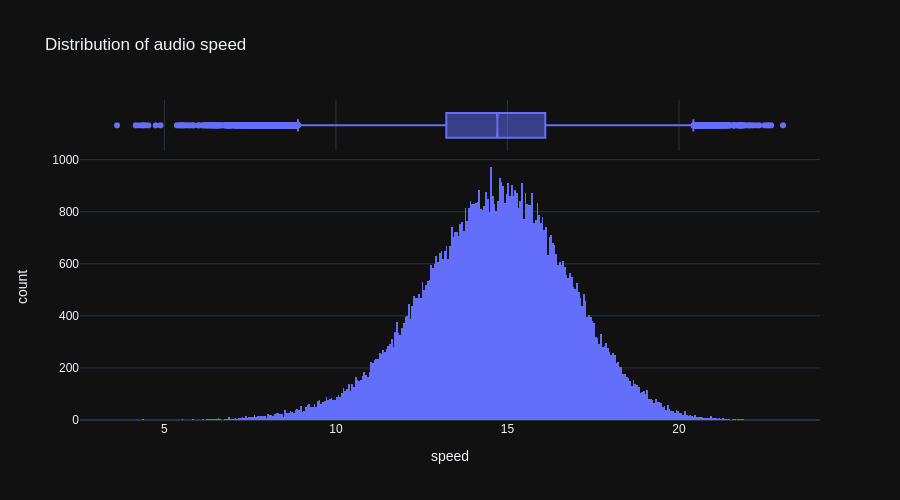

In [45]:
fig = px.histogram(data, x="speed", marginal="box", nbins=500, template='plotly_dark',
                  title='Distribution of audio speed')
Image(pio.to_image(fig, format='png', width=900))


In [46]:
min = 11
initial_size = data.shape[0]
data = data[data['speed'] >= min]
print(f'percentage of data lost after removing audio files with less than {min} char per second: '
     f'{(((initial_size-data.shape[0])/initial_size) * 100):.4f}%')

percentage of data lost after removing audio files with less than 11 char per second: 5.2038%


In [47]:
max = 18
initial_size = data.shape[0]
data = data[data['speed'] <= max]
print(f'percentage of data lost after removing audio files with greater than {max} char per second: '
     f'{(((initial_size-data.shape[0])/initial_size) * 100):.4f}%')


percentage of data lost after removing audio files with greater than 18 char per second: 5.6680%


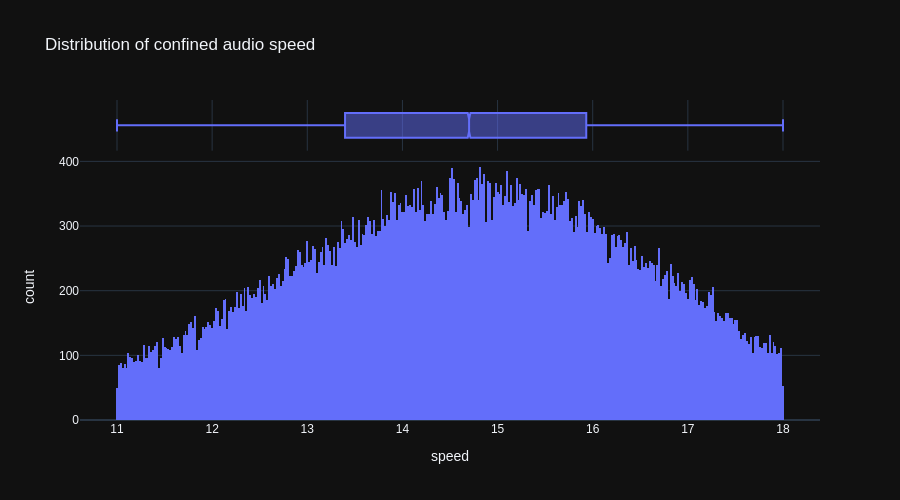

In [48]:
fig = px.histogram(data, x="speed", marginal="box", nbins=500, template='plotly_dark', title='Distribution of confined audio speed')
Image(pio.to_image(fig, format='png', width=900))

In [49]:
data.shape

(84030, 6)

### Char_length

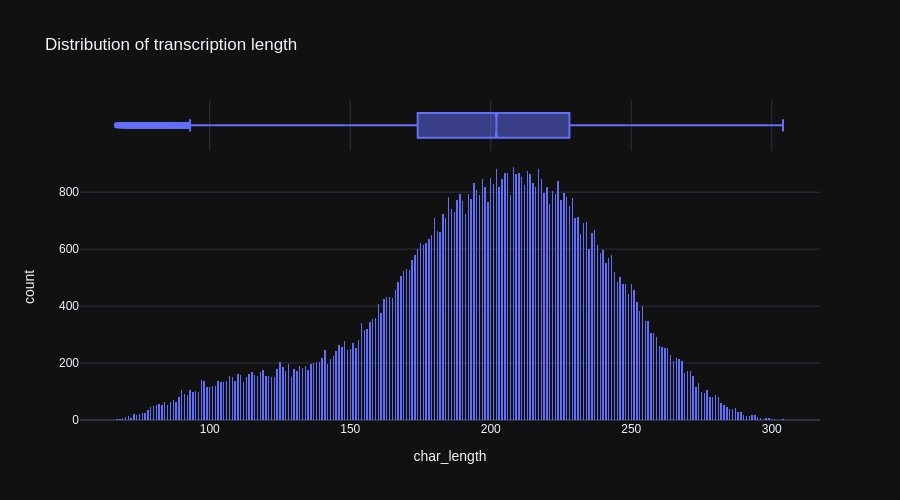

In [50]:
fig = px.histogram(data, x="char_length", marginal="box", nbins=500, template='plotly_dark',
                   title='Distribution of transcription length',)
Image(pio.to_image(fig, format='png', width=900))

In [51]:
min = 70
initial_size = data.shape[0]
data = data[data['char_length'] >= min] 
print(f'percentage of data lost after removing less than {min} character transcriptions: '
      f'{(((initial_size-data.shape[0])/initial_size) * 100):.4f}%')

percentage of data lost after removing less than 70 character transcriptions: 0.0155%


In [52]:
max = 270
initial_size = data.shape[0]
data = data[data['char_length'] <= max]
print(f'percentage of data lost after removing more than {max} 51 character transcriptions: '
      f'{(((initial_size-data.shape[0])/initial_size) * 100):.4f}%')

percentage of data lost after removing more than 270 51 character transcriptions: 1.9794%


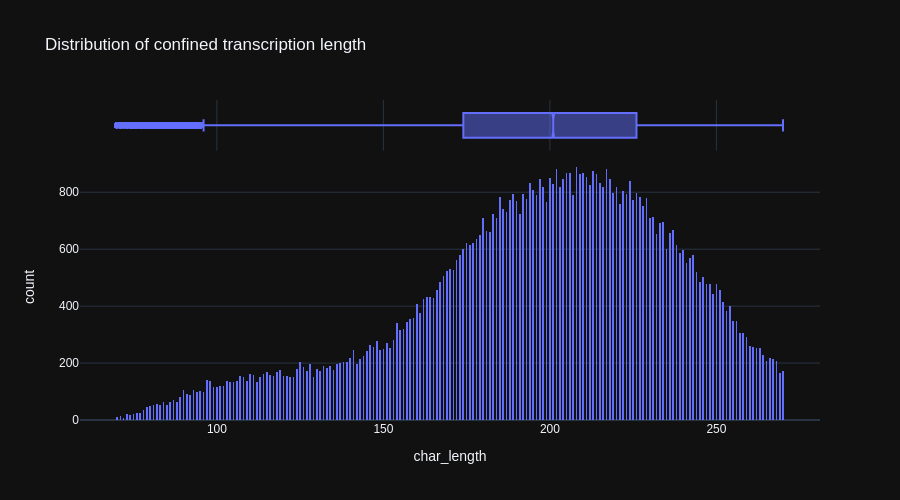

In [53]:
fig = px.histogram(data, x="char_length", marginal="box", nbins=500, template='plotly_dark',
                   title='Distribution of confined transcription length')
Image(pio.to_image(fig, format='png', width=900))

In [54]:
data.shape

(82354, 6)

### Train-Val-Split

In [55]:
data = data.sample(
    frac=1, random_state=11).reset_index(drop=True)
split = int(len(data) * 0.90)
df_train = data[:split]
df_val = data[split:]


print(f"Size of the training set: {len(df_train)}")
print(f"Size of the testing set: {len(df_val)}")
print(f"Size of the testing set: {len(df_val)}")

Size of the training set: 74118
Size of the testing set: 8236
Size of the testing set: 8236


sort values for higher batch-consistency

In [89]:
df_val.sort_values(by=["char_length"], inplace=True, ascending=False)
df_val.reset_index(drop=True, inplace=True)

df_train.sort_values(by=["char_length"], inplace=True, ascending=False)
df_train.reset_index(drop=True, inplace=True)

data_test.sort_values(by=["char_length"], inplace=True, ascending=True)
data_test.reset_index(drop=True, inplace=True)
data_test.tail(3)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,file_path,key,transcription,duration,char_length,speed
2617,/content/drive/MyDrive/LibriSpeech/test-clean/...,5639-40744-0031,so persuasive were her entreaties and so stron...,12.95,468,36.138996
2618,/content/drive/MyDrive/LibriSpeech/test-clean/...,3570-5696-0003,a reconciliation between the two conflicting r...,12.77,474,37.118246
2619,/content/drive/MyDrive/LibriSpeech/test-clean/...,1995-1836-0004,as she awaited her guests she surveyed the tab...,14.04,576,41.025641


### Tokenization

In [57]:
# The set of characters accepted in the transcription.
characters = [x for x in "abcdefghijklmnopqrstuvwxyz' "]
# Mapping characters to integers
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
# Mapping integers back to original characters
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)


The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", ' '] (size =29)


Mel-Spectrogram

In [58]:
def encode_single_sample_mel(filepath, label, sr=16000, n_fft=2048, stride=128, window=256, n_mels=256):
    audio = tf.io.read_file(filepath)
    audio = tfio.audio.decode_flac(audio, dtype=tf.int16)
    audio = audio / tf.reduce_max(audio)
    audio = tf.squeeze(audio, axis=-1)
    audio = tf.cast(audio, tf.float32)

    spectrogram = tfio.audio.spectrogram(
        audio, nfft=n_fft, window=window, stride=stride)

    mel_spectrogram = tfio.audio.melscale(
        spectrogram, rate=sr, mels=n_mels, fmin=0, fmax=sr/2)

    dbscale_mel_spectrogram = tfio.audio.dbscale(
        mel_spectrogram, top_db=80)
    
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    label = char_to_num(label)
    return dbscale_mel_spectrogram, label


In [90]:
# batch size of 32 for GPU-RAM of 16GB (Tesla V100-SXM2-16GB)
# batch size of 64 for GPU-RAM of 40GB (A100-SXM4-40GB)
batch_size = 64
# Define the trainig dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["file_path"]), list(df_train["transcription"]))
)
train_dataset = (
    train_dataset.map(encode_single_sample_mel, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["file_path"]), list(df_val["transcription"]))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample_mel, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)
# Define the test dataset
test_dataset = tf.data.Dataset.from_tensor_slices(
    (list(data_test["file_path"]), list(data_test["transcription"]))
)
test_dataset = (
    test_dataset.map(encode_single_sample_mel, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

to this he in the green gaban replied i sir knight of the rueful countenance am a gentleman by birth native of the village where please god we are going to dine today i am more than fairly well off and my name is don diego de miranda


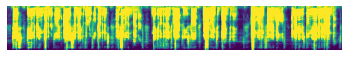

(256, 1967)


In [60]:
audio_file = data.file_path[2]
label = data.transcription[2]
print(label)

mel_spectrogram, mel_label = encode_single_sample_mel(
   audio_file, label)
mel_spectrogram = np.array([np.trim_zeros(x)
                           for x in np.transpose(mel_spectrogram)])
plt.imshow(mel_spectrogram, vmax=1)
plt.axis("off")
plt.savefig(MEDIA_PATH+'log_mel_spec.png')
plt.show()
print(mel_spectrogram.shape)


In [61]:
for batch in train_dataset.take(1):
    label_tokens = batch[1][1]
    print(label_tokens)
    label = tf.strings.reduce_join(num_to_char(label_tokens)).numpy().decode("utf-8")
    print(label)

tf.Tensor(
[23  9 20  8 15 21 20 28 19  5 14 19  5 28 15  6 28 20  8  5 28 12  1 23
 19 28 15  6 28 11  9 14  4 14  5 19 19 28  7 15 15  4 28 14  1 20 21 18
  5 28 13 21 20 21  1 12 28 15  6  6  9  3  5 19 28  1 14  4 28 20  8  5
 28  5 12  5  7  1 14 20 28 19  1 20  9 19  6  1  3 20  9 15 14 19 28 23
  8  9  3  8 28  6 12 15 23 28  6 18 15 13 28 18  5  1 19 15 14 28  1 14
  4 28 22  9 18 20 21  5 28 20  8  5 28 22  5 24  1 20  9 15 21 19 28 12
  9  6  5 28  1 18  9 19  5 19 28  6 18 15 13 28  1 28  3 15 14 10 21 14
  3 20  9 15 14 28 15  6 28 20 23 15 28 16  5 15 16 12  5 28 15  6 28 17
 21  9  3 11 28 20  1 19 20  5 28  1 14  4 28 18  5 19  5 14 20 13  5 14
 20 28 16 21 20 28 20 15  7  5 20  8  5 18 28  6 15 18 28 18  5  1 19 15
 14 19 28 23  5 12 12 28 11 14 15 23 14 28 20 15 28 20  8  5  9 18 28  6
 18  9  5 14  4 19], shape=(270,), dtype=int64)
without sense of the laws of kindness good nature mutual offices and the elegant satisfactions which flow from reason and virtue the vexat

## THE MODEL


In [62]:
def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(
        y_true, y_pred, input_length, label_length)
    return loss


### https://nvidia.github.io/OpenSeq2Seq/html/speech-recognition/deepspeech2.html

In [63]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    """Model similar to DeepSpeech2."""
    # Model's input
    input_spectrogram = layers.Input((None, input_dim), name="input")
    # Expand the dimension to use 2D CNN.
    x = layers.Reshape((-1, input_dim, 1),
                       name="expand_dim")(input_spectrogram)
    # Convolution layer 1
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    #x = layers.ReLU(name="conv_1_relu")(x)
    x = tfa.layers.GELU(name="conv_1_gelu")(x)
    # Convolution layer 2
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    #x = layers.ReLU(name="conv_2_relu")(x)
    x = tfa.layers.GELU(name="conv_2_gelu")(x)
    # Reshape the resulted volume to feed the RNNs layers
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
    # RNN layers
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}",
        )
        x = layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)
    # Dense layer
    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    #x = layers.ReLU(name="dense_1_relu")(x)
    x = tfa.layers.GELU(name="dense_1_gelu")(x)
    x = layers.Dropout(rate=0.5)(x)
    # Classification layer
    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)
    # Model
    model = keras.Model(input_spectrogram, output, name="DeepSpeech_2")
    # Optimizer
    #opt = keras.optimizers.Adam(learning_rate=1e-4)
    opt = keras.optimizers.SGD(learning_rate=0.0008, decay=1e-5, momentum=0.9, nesterov=True, clipnorm=5) #(lr=0.0005, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
    # Compile the model and return
    model.compile(optimizer=opt, loss=CTCLoss)
    return model


# Get the model
n_mels=256
model = build_model(
    input_dim=n_mels, #fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
)
model.summary(line_length=110)


Model: "DeepSpeech_2"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 input (InputLayer)                              [(None, None, 256)]                         0                
                                                                                                              
 expand_dim (Reshape)                            (None, None, 256, 1)                        0                
                                                                                                              
 conv_1 (Conv2D)                                 (None, None, 128, 32)                       14432            
                                                                                                              
 conv_1_bn (BatchNormalization)                  (None, None, 128, 32)                    

### Training & Evaluating

In [64]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(
        pred, input_length=input_len, greedy=True)[0][0]     
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(
            num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text


# A callback class to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(num_to_char(
                        label)).numpy().decode("utf-8")
                )
                targets.append(label)
        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)
        # A csv-file to store the wer-score after each epoch for evaluation
        with open(MODEL_PATH+MODEL_NAME+"_wer.csv", 'a') as wer_file:
            wer_file.write(f"{str(epoch)};{str(wer_score)}\n")

        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)


In [65]:
MODEL_NAME = 'RNN_mel'
# Define the number of epochs.
epochs = 50

model = keras.models.load_model(filepath=MODEL_PATH+MODEL_NAME+".h5", custom_objects={'CTCLoss':CTCLoss})
# Callback function to check transcription on the val set.
validation_callback = CallbackEval(validation_dataset)

mc = ModelCheckpoint(filepath=MODEL_PATH+MODEL_NAME+".h5", verbose=1, save_best_only=True)
es = EarlyStopping(monitor="val_loss", patience=3, verbose=1)
csv_logger = CSVLogger(MODEL_PATH+'training.log', separator=';', append=True)

# Train the model
history = model.fit(
   train_dataset,
   validation_data=validation_dataset,
   epochs=epochs,
   callbacks=[validation_callback, es, mc, csv_logger],
)

Epoch 1/50
1159/1159 [==============================] - ETA: 0s - loss: 24.8258----------------------------------------------------------------------------------------------------
Word Error Rate: 0.1419
----------------------------------------------------------------------------------------------------
Target    : life and love and death that irresistible needle touch as one of her best critics has called it piercing at once the very core of a thought has found a response as wide and sympathetic as it has been unexpected even to those who knew best her compelling power
Prediction: life and love and death that irresistible needletouch as one of herbest critics as called it piercing at once the very coure of athought has found a responseis wide and sympathetic as it has been unexpected even to those who knew best her compelling power
----------------------------------------------------------------------------------------------------
Target    : well let's forget our troubles and think o

In [66]:
model.save(MODEL_PATH+MODEL_NAME+'_SavedModel')


INFO:tensorflow:Assets written to: /content/drive/MyDrive/LibriSpeech/model/RNN_mel_SavedModel/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/LibriSpeech/model/RNN_mel_SavedModel/assets


In [67]:
model.save(MODEL_PATH+MODEL_NAME+'_last.h5')

In [68]:
joblib.dump(history.history, MODEL_PATH+MODEL_NAME+'_history.bin')

['/content/drive/MyDrive/LibriSpeech/model/RNN_mel_history.bin']

In [69]:
#history_df = pd.read_csv(MODEL_PATH+MODEL_NAME+'_history.csv')
#history_new = joblib.load(model_path+model_name+'_history.bin')

In [70]:
#history__new_df = pd.DataFrame(history_new)
#history_df = pd.concat([history_df, history_new_df], ignore_index=True)
#history_df.plot()

In [71]:
history_df = pd.DataFrame(history.history)

In [72]:
history_df.to_csv(MODEL_PATH+MODEL_NAME+"_history.csv", index=None)

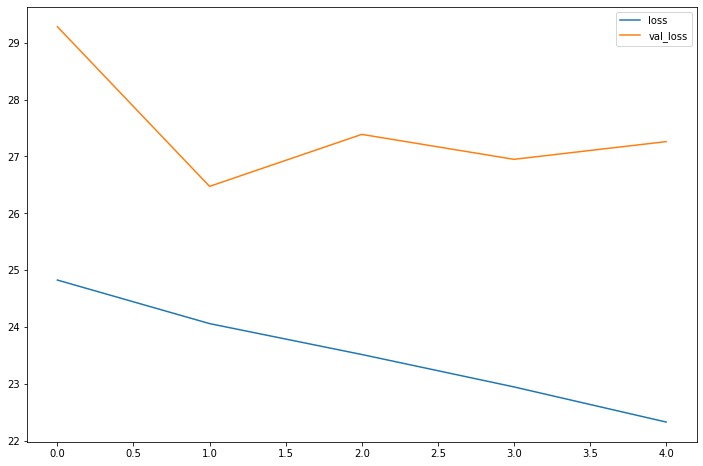

In [75]:
def plot_history(history):
    plt.figure(figsize=(12, 8))
    plt.plot(history['loss'], label="loss")
    plt.plot(history['val_loss'], label="val_loss")
    plt.legend()
    # time = strftime("%Y-%m-%d-%H:%M", gmtime())
    plt.savefig(MEDIA_PATH+MODEL_NAME+'_history.png', dpi=300)
    plt.show()
    
plot_history(history_df)

### Inference

In [91]:
predictions = []
targets = []
for batch in test_dataset:
    X, y = batch
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(
            num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)
wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Target    : {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print("-" * 100)


----------------------------------------------------------------------------------------------------
Word Error Rate: 0.1409
----------------------------------------------------------------------------------------------------
Target    : he had the faith in him that moves mountains
Prediction: he had the faith in him that moves mountains
----------------------------------------------------------------------------------------------------
Target    : but you know more about that than i do sir
Prediction: but you know more about that that i do sir
----------------------------------------------------------------------------------------------------
Target    : harangue the tiresome product of a tireless tongue
Prediction: her rang the tiresome product of attireless tongue
----------------------------------------------------------------------------------------------------
Target    : i was thinking it's very like the ace of hearts answered the captain softly smiling on
Prediction: i was thin

In [79]:
def encode_audio(file, sr=16000, n_fft=2024, stride=128, window=256, n_mels=256, flac=True):
    if flac:
        audio = tf.io.read_file(file)
        audio = tfio.audio.decode_flac(audio, dtype=tf.int16)
        audio = audio / np.max(audio)
        audio = tf.squeeze(audio, axis=-1)
        audio = tf.cast(audio, tf.float32)
        spectrogram = tfio.audio.spectrogram(audio, nfft=n_fft, window=window, stride=stride)
        mel_spectrogram = tfio.audio.melscale(spectrogram, rate=sr, mels=n_mels, fmin=0, fmax=sr/2)
        dbscale_mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=80)
        return dbscale_mel_spectrogram
    else:
        audio = tf.io.read_file(file)
        audio = tfio.audio.decode_wav(audio, dtype=tf.int16)
        audio = audio / np.max(audio)
        audio = tf.squeeze(audio, axis=-1)
        audio = tf.cast(audio, tf.float32)
        spectrogram = tfio.audio.spectrogram(audio, nfft=n_fft, window=window, stride=stride)
        mel_spectrogram = tfio.audio.melscale(spectrogram, rate=sr, mels=n_mels, fmin=0, fmax=sr/2)
        dbscale_mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=80)
        return dbscale_mel_spectrogram

def decode_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    result = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    print(result)
    result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
    return result


In [92]:
my_file = RECORDINGS_PATH+"the_jungle_book1.wav"
print(my_file)
recording = encode_audio(my_file, sr=16000, flac=False) # for wav-files: flac=false
recording = np.expand_dims(recording, axis=0)
recording.shape
#tfio.audio.resample(input, rate_in, rate_out, name=None)


/content/drive/MyDrive/LibriSpeech/my_recordings/the_jungle_book1.wav


(1, 750, 256)

In [93]:
ipd.Audio(my_file)

In [94]:
output= model.predict(recording)
output = decode_predictions(output)
print(output)

tf.Tensor(
[[ 1 14  4 28  8  5 28  7 18  5 23 28 22  5 18 25 28 20  9 18  5  4 28 15
   6 28 19  1 25  9 14  7 28 20  8  5 28 19  1 13  5 28 20  8  9 14  7 28
  15 22  5 18 28  1 28  8 21 14  4 18  5  4 28 20  9 13  5 19 -1 -1 -1 -1
  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1 -1 -1 -1 -1 -